In [94]:
%pip install yfinance scikit-learn matplotlib pandas ipywidgets tqdm


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [95]:
from utils.SeriesProcessor import SeriesProcessor
from classes.frameworkDetector.framework_detector import FrameworkDetector

# Importações necessárias (adicione no início do notebook)
import numpy as np
import copy
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils import Visualizer

from classes.detectores.ADWINDetector import ADWINDetector
from classes.detectores.DDMDetector import DDMDetector
from classes.detectores.EDDMDetector import EDDMDetector
from classes.detectores.FHDDMDetector import FHDDMDetector
from classes.detectores.HDDM_ADetector import HDDM_ADetector
from classes.detectores.PageHinkleyDetector import PageHinkleyDetector
from classes.detectores.HDDM_WDetector import HDDM_WDetector
from classes.detectores.KSWINDetector import KSWINDetector

# **1. Preparação da Base de Dados**

In [96]:
# Lista de séries temporais disponíveis (para referência)
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

# Definindo parâmetros para processamento
lags = 5
serie_escolhida = series[-2]  # Exemplo: ^BVSP
print(f"Processando série: {serie_escolhida}")

# Baixando os dados
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal_normalizada = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal_normalizada.shape}")

# Gerando janelas temporais (features X e target Y)
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal_normalizada, lags)
print(f"Shape dos dados de entrada (X): {X.shape}")
print(f"Shape dos dados de saída (Y): {Y.shape}")

# Definindo tamanho do conjunto inicial de treinamento (por exemplo, 20% dos dados)
initial_size = int(0.2 * len(X))
print(f"Tamanho do conjunto inicial de treinamento: {initial_size} amostras")

# Dividindo os dados em conjunto inicial e streaming
X_init = X[:initial_size]
y_init = Y[:initial_size]
X_stream = X[initial_size:]
Y_stream = Y[initial_size:]

print(f"Shape do X_init: {X_init.shape}")
print(f"Shape do Y_init: {y_init.shape}")
print(f"Shape do X_stream: {X_stream.shape}")
print(f"Shape do Y_stream: {Y_stream.shape}")

# Alternativamente, você pode definir um número fixo de amostras iniciais
# Por exemplo, 100 primeiras amostras para treinamento
fixed_initial_size = 100
X_init_fixed = X[:fixed_initial_size]
Y_init_fixed = Y[:fixed_initial_size]
X_stream_fixed = X[fixed_initial_size:]
Y_stream_fixed = Y[fixed_initial_size:]

print("\nCom tamanho fixo:")
print(f"Shape do X_init_fixed: {X_init_fixed.shape}")
print(f"Shape do Y_init_fixed: {Y_init_fixed.shape}")
print(f"Shape do X_stream_fixed: {X_stream_fixed.shape}")
print(f"Shape do Y_stream_fixed: {Y_stream_fixed.shape}")

Processando série: ^BVSP


[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1244, 1)
Shape dos dados de entrada (X): (1239, 5)
Shape dos dados de saída (Y): (1239, 1)
Tamanho do conjunto inicial de treinamento: 247 amostras
Shape do X_init: (247, 5)
Shape do Y_init: (247, 1)
Shape do X_stream: (992, 5)
Shape do Y_stream: (992, 1)

Com tamanho fixo:
Shape do X_init_fixed: (100, 5)
Shape do Y_init_fixed: (100, 1)
Shape do X_stream_fixed: (1139, 5)
Shape do Y_stream_fixed: (1139, 1)


In [97]:
# 2. Dados Reais de Séries Financeiras
def preparar_dados_financeiros(ticker="^BVSP", periodo="5y", lags=10):
    """Prepara dados de séries financeiras para experimentos"""
    print(f"Baixando dados para {ticker} nos últimos {periodo}...")

    # Baixar dados
    serie_temporal = SeriesProcessor.baixar_dados(ticker, periodo)

    # Pré-processamento
    serie_normalizada = SeriesProcessor.normalizar_serie(serie_temporal)

    # Criar janelas temporais
    X, y = SeriesProcessor.criar_janela_temporal(serie_normalizada, lags)

    print(f"Dados processados: {X.shape[0]} amostras com {X.shape[1]} features")

    return X, y, serie_temporal

In [98]:
def executar_framework(X, y,
                      detector_tipo="DDM",
                      tamanho_inicial=200,
                      tamanho_janela=50,
                      desempenho_minimo=0.5,
                      modelo_base=None,
                      verbose=True):
    """
    Executa o framework de detecção e adaptação em um conjunto de dados

    Parâmetros:
    -----------
    X : ndarray
        Features de entrada
    y : ndarray
        Valores alvo
    detector_tipo : str
        Tipo de detector a ser usado (DDM, ADWIN, EDDM, FHDDM, etc.)
    tamanho_inicial : int
        Número de amostras para treinamento inicial
    tamanho_janela : int
        Tamanho da janela de dados recentes
    desempenho_minimo : float
        Limiar mínimo de desempenho para manter um modelo
    modelo_base : object
        Modelo de base para inicializar (se None, usa LinearRegression)
    verbose : bool
        Se True, exibe informações detalhadas sobre o processamento

    Retorna:
    --------
    dict
        Resultados do experimento com métricas e estados
    """
    # Dividir dados
    X_init, y_init = X[:tamanho_inicial], y[:tamanho_inicial]
    X_stream, y_stream = X[tamanho_inicial:], y[tamanho_inicial:]

    if verbose:
        print(f"Treinamento inicial: {len(X_init)} amostras, Stream: {len(X_stream)} amostras")

    # Inicializar modelos
    pool_modelos = FrameworkDetector.treinar_modelos_iniciais(X_init, y_init)
    modelo_atual = pool_modelos[0]  # Começa com o primeiro modelo

    if verbose:
        print(f"Pool inicial contém {len(pool_modelos)} modelos")

    # Inicializar detector baseado no tipo escolhido
    detector = None
    if detector_tipo == "DDM":
        detector = DDMDetector()
    elif detector_tipo == "ADWIN":
        detector = ADWINDetector()
    elif detector_tipo == "EDDM":
        detector = EDDMDetector()
    elif detector_tipo == "FHDDM":
        detector = FHDDMDetector()
    elif detector_tipo == "HDDM_A":
        detector = HDDM_ADetector()
    elif detector_tipo == "HDDM_W":
        detector = HDDM_WDetector()
    elif detector_tipo == "PageHinkley":
        detector = PageHinkleyDetector()
    elif detector_tipo == "KSWIN":
        detector = KSWINDetector()
    else:
        raise ValueError(f"Detector '{detector_tipo}' não suportado")

    # Estruturas para armazenar resultados
    janela_dados_recentes = []

    # Métricas
    erros_predicao = []
    estados_detector = []
    pontos_drift = []
    metricas_rmse = []
    metricas_mae = []
    metricas_r2 = []
    previsoes = []
    valores_reais = []

    # Processamento do stream
    if verbose:
        print("Processando stream de dados...")
        iterator = tqdm(enumerate(zip(X_stream, y_stream)), total=len(X_stream))
    else:
        iterator = enumerate(zip(X_stream, y_stream))

    for i, (x_t, y_t) in iterator:
        # Adaptar formato para previsão
        x_t_reshaped = x_t.reshape(1, -1)

        # 1. Predição
        try:
            y_pred = modelo_atual.prever(x_t_reshaped)[0]
        except Exception as e:
            if verbose:
                print(f"Erro na predição: {e}")
            y_pred = np.mean(y_init)  # Fallback para média dos dados iniciais

        # Armazenar para análise posterior
        previsoes.append(y_pred)
        valores_reais.append(y_t)

        # 2. Cálculo do erro e atualização do detector
        erro = abs(y_t - y_pred)
        detector.atualizar(erro)

        # 3. Obter estado do detector
        estado = FrameworkDetector.get_state(detector)  # 'NORMAL', 'ALERTA', 'MUDANÇA'

        # 4. Ação baseada no estado
        if estado == "NORMAL":
            # Apenas armazena os dados recentes
            janela_dados_recentes.append((x_t, y_t))
            if len(janela_dados_recentes) > tamanho_janela:
                janela_dados_recentes.pop(0)

        elif estado == "ALERTA":
            # Adapta o modelo se suportar aprendizado incremental
            if hasattr(modelo_atual, "partial_fit"):
                modelo_atual.partial_fit(x_t_reshaped, np.array([y_t]))

            janela_dados_recentes.append((x_t, y_t))
            if len(janela_dados_recentes) > tamanho_janela:
                janela_dados_recentes.pop(0)

        elif estado == "MUDANÇA":
            # Registra o ponto de drift
            ponto_drift = tamanho_inicial + i
            pontos_drift.append(ponto_drift)

            if verbose:
                print(f"Drift detectado no ponto {ponto_drift}")

            # Adiciona o modelo atual ao pool se não for None
            if modelo_atual is not None:
                pool_modelos.append(copy.deepcopy(modelo_atual))

            # Seleciona o melhor modelo do pool
            if len(janela_dados_recentes) > 5:  # Só se tivermos dados suficientes
                melhor_modelo = FrameworkDetector.selecionar_melhor_modelo(pool_modelos, janela_dados_recentes)

                # Avalia o desempenho do melhor modelo na janela recente
                desempenho = FrameworkDetector.avaliar_desempenho(melhor_modelo, janela_dados_recentes)

                # Se o desempenho for adequado, usa o melhor modelo do pool
                if desempenho <= desempenho_minimo:  # Menor erro é melhor
                    modelo_atual = melhor_modelo
                    if verbose:
                        print(f"Usando modelo do pool com erro médio: {desempenho:.4f}")
                else:
                    # Caso contrário, treina um novo modelo com dados recentes
                    if verbose:
                        print("Treinando novo modelo...")

                    # Cria um modelo baseado no tipo escolhido
                    if modelo_base is None:
                        novo_modelo_base = LinearRegression()
                    else:
                        novo_modelo_base = copy.deepcopy(modelo_base)

                    # Extrai dados da janela
                    X_recente = np.array([x for x, _ in janela_dados_recentes])
                    y_recente = np.array([y for _, y in janela_dados_recentes])

                    # Treina o novo modelo
                    try:
                        novo_modelo_base.fit(X_recente, y_recente)
                        modelo_atual = FrameworkDetector.criar_modelo_wrapper(novo_modelo_base)
                    except Exception as e:
                        if verbose:
                            print(f"Erro ao treinar novo modelo: {e}")
                        # Mantém o melhor modelo do pool como fallback
                        modelo_atual = melhor_modelo
            else:
                # Se não tivermos dados suficientes, mantemos o modelo atual
                if verbose:
                    print("Poucos dados na janela. Mantendo modelo atual.")

            # Mantém alguns dados recentes para inicializar a nova janela
            janela_dados_recentes = janela_dados_recentes[-10:] if len(janela_dados_recentes) > 10 else janela_dados_recentes

        # Armazenar métricas e estados
        erros_predicao.append(erro)
        estados_detector.append(estado)

        # Calcular métricas de desempenho periodicamente
        if i % 50 == 0 and len(janela_dados_recentes) > 5:
            X_janela = np.array([x for x, _ in janela_dados_recentes])
            y_janela = np.array([y for _, y in janela_dados_recentes])
            y_prev = modelo_atual.prever(X_janela)

            try:
                rmse = np.sqrt(mean_squared_error(y_janela, y_prev))
                mae = mean_absolute_error(y_janela, y_prev)
                r2 = r2_score(y_janela, y_prev)

                metricas_rmse.append((tamanho_inicial + i, rmse))
                metricas_mae.append((tamanho_inicial + i, mae))
                metricas_r2.append((tamanho_inicial + i, r2))
            except Exception as e:
                if verbose:
                    print(f"Erro ao calcular métricas: {e}")

    # Preparar resultados
    resultados = {
        "detector": detector_tipo,
        "pool_modelos": pool_modelos,
        "modelo_final": modelo_atual,
        "erros_predicao": erros_predicao,
        "estados_detector": estados_detector,
        "pontos_drift": pontos_drift,
        "metricas_rmse": metricas_rmse,
        "metricas_mae": metricas_mae,
        "metricas_r2": metricas_r2,
        "previsoes": previsoes,
        "valores_reais": valores_reais
    }

    return resultados

# **2. Inicialização**

In [ ]:
pool_modelos = FrameworkDetector.treinar_modelos_iniciais(X=X_init, y=y_init)
modelo_atual = pool_modelos[0]
detector_escolhido = "KSWIN"

# Detector dinâmico
if detector_escolhido == "DDM":
    detector = DDMDetector()
elif detector_escolhido == "ADWIN":
    detector = ADWINDetector()
elif detector_escolhido == "KSWIN":
    detector = KSWINDetector()
elif detector_escolhido == "HDDM_A":
    detector = HDDM_ADetector()
elif detector_escolhido == "HDDM_W":
    detector = HDDM_WDetector()
elif detector_escolhido == "PageHinkley":
    detector = PageHinkleyDetector()

janela_dados_recentes = []

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iniciando treinamento dos modelos iniciais...
Treinando modelo SVR...
✅ Modelo SVR treinado com sucesso
Treinando modelo Random Forest...
✅ Modelo Random Forest treinado com sucesso
Treinando modelo KNN...
✅ Modelo KNN treinado com sucesso
✓ Total de modelos treinados com sucesso: 3
  1. SVRModelo
  2. RandomForestModelo
  3. KNeighborsRegressorModelo


Baixando dados para ^BVSP nos últimos 5y...


[*********************100%***********************]  1 of 1 completed
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Dados processados: 1239 amostras com 5 features
Treinamento inicial: 200 amostras, Stream: 1039 amostras
Iniciando treinamento dos modelos iniciais...
Treinando modelo SVR...
✅ Modelo SVR treinado com sucesso
Treinando modelo Random Forest...
✅ Modelo Random Forest treinado com sucesso
Treinando modelo KNN...
✅ Modelo KNN treinado com sucesso
✓ Total de modelos treinados com sucesso: 3
  1. SVRModelo
  2. RandomForestModelo
  3. KNeighborsRegressorModelo
Pool inicial contém 3 modelos
Processando stream de dados...


  0%|          | 0/1039 [00:00<?, ?it/s]

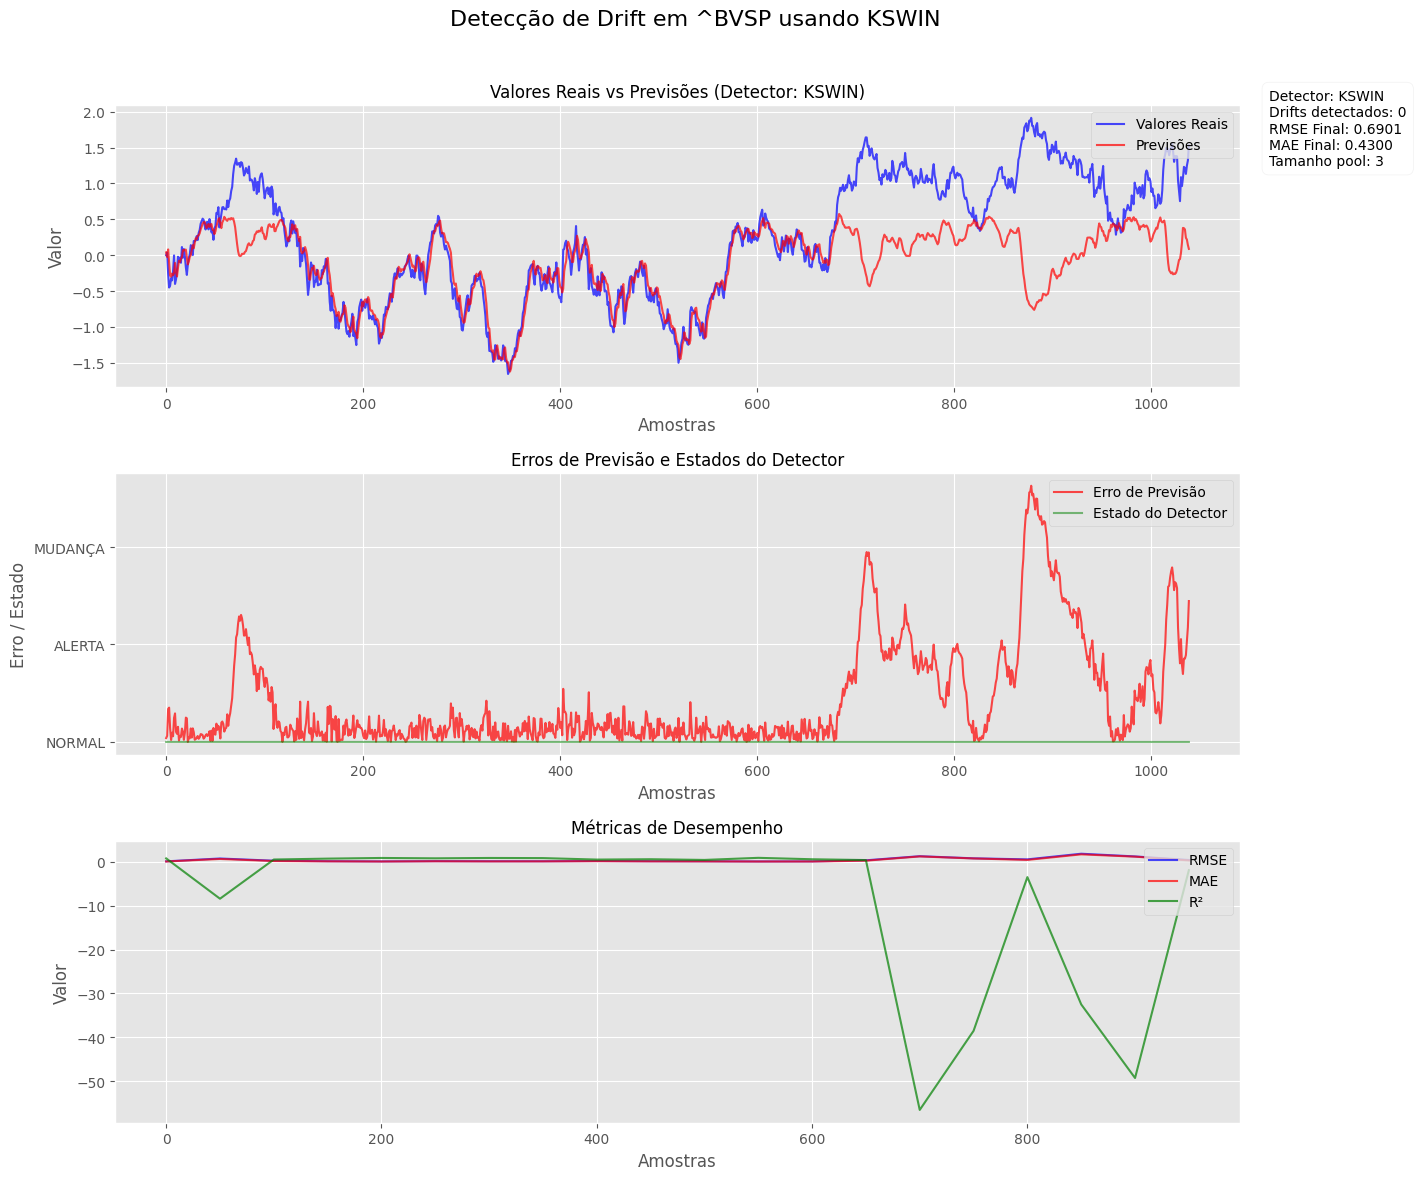


Detector: KSWIN
Total de amostras processadas: 1039
Número de drifts detectados: 0
RMSE final: 0.6901
MAE final: 0.4300


In [100]:
ticker = "^BVSP"  # Índice Bovespa
lags = 5
periodo = "5y"

X, y, serie_temporal = preparar_dados_financeiros(ticker=ticker, periodo=periodo, lags=lags)

# Executar framework com detector DDM
resultados_ddm = executar_framework(
    X=X,
    y=y,
    detector_tipo=detector_escolhido,
    tamanho_inicial=200,
    tamanho_janela=50,
    desempenho_minimo=0.05,
    verbose=True
)

# Visualizar resultados
Visualizer.visualizar_resultados(resultados_ddm, serie_temporal=serie_temporal,
                          titulo=f"Detecção de Drift em {ticker} usando {resultados_ddm['detector']}")

In [101]:
# Testar criação do pool de modelos
print("\n=== Teste do Pool de Modelos ===")
X_teste = X[:200]  # Usar algumas amostras para teste
y_teste = y[:200]

print(f"Treinando vários modelos com {len(X_teste)} amostras...")
pool_teste = FrameworkDetector.treinar_modelos_iniciais(X_teste, y_teste)

print(f"\nPool gerado contém {len(pool_teste)} modelos:")
for i, modelo in enumerate(pool_teste):
    # Tentar obter o nome do modelo
    if hasattr(modelo, 'nome'):
        nome = modelo.nome
    elif hasattr(modelo, '__class__'):
        nome = modelo.__class__.__name__
    else:
        nome = f"Modelo #{i+1}"

    print(f"{i+1}. {nome}")

# Se houver modelos no pool, testar previsões
if len(pool_teste) > 0:
    x_exemplo = X_teste[0].reshape(1, -1)
    print("\nTestando previsões:")
    for i, modelo in enumerate(pool_teste):
        try:
            pred = modelo.prever(x_exemplo)[0]
            print(f"Modelo {i+1}: predição = {pred:.4f}")
        except Exception as e:
            print(f"Modelo {i+1}: erro na previsão - {e}")


=== Teste do Pool de Modelos ===
Treinando vários modelos com 200 amostras...
Iniciando treinamento dos modelos iniciais...
Treinando modelo SVR...
✅ Modelo SVR treinado com sucesso
Treinando modelo Random Forest...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


✅ Modelo Random Forest treinado com sucesso
Treinando modelo KNN...
✅ Modelo KNN treinado com sucesso
✓ Total de modelos treinados com sucesso: 3
  1. SVRModelo
  2. RandomForestModelo
  3. KNeighborsRegressorModelo

Pool gerado contém 3 modelos:
1. SVRModelo
2. RandomForestModelo
3. KNeighborsRegressorModelo

Testando previsões:
Modelo 1: predição = -2.9091
Modelo 2: predição = -2.9404
Modelo 3: erro na previsão - unsupported format string passed to numpy.ndarray.__format__



=== Pool de Modelos (3 modelos) ===

Modelo #1:
Tipo: SVRModelo
Parâmetros:
  C: 1.0
  cache_size: 200
  coef0: 0.0
  degree: 3
  epsilon: 0.1
  gamma: scale
  kernel: rbf
  max_iter: -1
  shrinking: True
  tol: 0.001
  verbose: False
Intercepto: [-1.23172879]

Modelo #2:
Tipo: RandomForestModelo
Parâmetros:
  bootstrap: True
  ccp_alpha: 0.0
  criterion: squared_error
  max_depth: None
  max_features: 1.0
  max_leaf_nodes: None
  max_samples: None
  min_impurity_decrease: 0.0
  min_samples_leaf: 1
  min_samples_split: 2
  min_weight_fraction_leaf: 0.0
  monotonic_cst: None
  n_estimators: 100
  n_jobs: None
  oob_score: False
  random_state: None
  verbose: 0
  warm_start: False

Modelo #3:
Tipo: KNeighborsRegressorModelo
Parâmetros:
  algorithm: auto
  leaf_size: 30
  metric: minkowski
  metric_params: None
  n_jobs: None
  n_neighbors: 5
  p: 2
  weights: uniform

=== Modelo Final ===
Tipo: SVRModelo
RMSE nas últimas 50 amostras: 1.0213
R² nas últimas 50 amostras: -13.5743


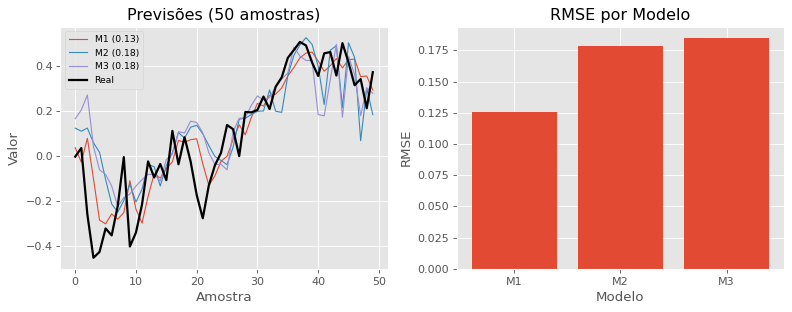


=== Resumo dos Modelos ===
M1: RMSE=0.1259
M2: RMSE=0.1786
M3: RMSE=0.1848

=== Análise de Overfitting ===
RMSE treino: 0.1293, teste: 0.4238, razão: 3.28
R² treino: 0.9829, teste: 0.6032
⚠️ Possível overfitting detectado!


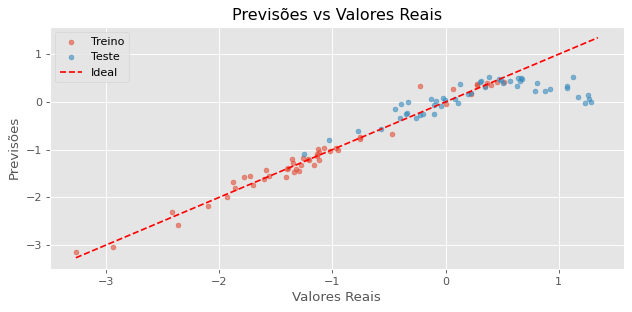

In [102]:
# Depois de executar o framework e obter resultados_ddm
FrameworkDetector.analisar_pool_modelos(resultados_ddm)

# Comparar modelos do pool
X_teste = X[200:] # Aqui nós podemos ajustar
y_teste = y[200:]
FrameworkDetector.comparar_modelos_pool(resultados_ddm, X_teste, y_teste)

# Analisar possível overfitting
FrameworkDetector.analisar_overfitting(resultados_ddm, X, y, tamanho_inicial=200)